# Backdoor Detector for BadNets

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

2023-12-04 19:57:52.254943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading dataset

In [3]:
def data_loader(filepath):
    data = h5py.File(filepath, "r")
    x_data = np.array(data["data"])
    y_data = np.array(data["label"])
    x_data = x_data.transpose((0, 2, 3, 1))

    return x_data, y_data

In [4]:
clean_valid_filepath = "data/cl/valid.h5"
clean_test_filepath = "data/cl/test.h5"
poisoned_valid_filepath = "data/bd/bd_valid.h5"
poisoned_test_filepath = "data/bd/bd_test.h5"

In [5]:
clean_x_valid, clean_y_valid = data_loader(clean_valid_filepath)
clean_x_test, clean_y_test = data_loader(clean_test_filepath)
bad_x_valid, bad_y_valid = data_loader(poisoned_valid_filepath)
bad_x_test, bad_y_test = data_loader(poisoned_test_filepath)

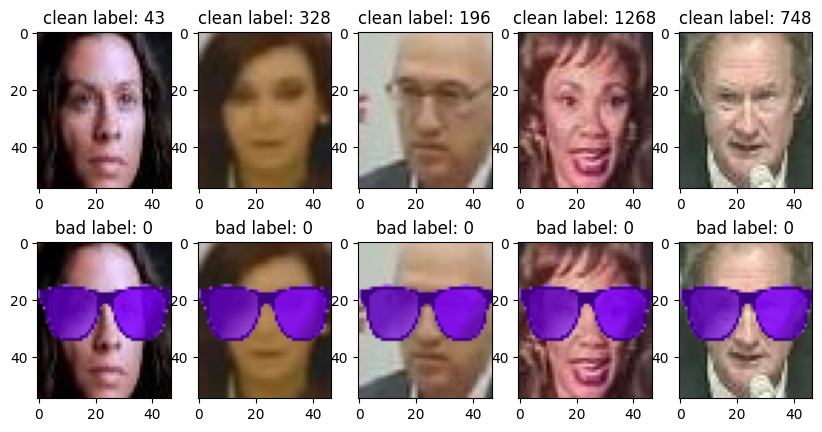

In [6]:
plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(clean_x_valid[i].astype(np.uint8))
    plt.title("clean label: {}".format(int(clean_y_valid[i])))

for i in range(5):
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(bad_x_valid[i].astype(np.uint8))
    plt.title("bad label: {}".format(int(bad_y_valid[i])))

plt.show()

### Analyzing the BadNet

In [7]:
badnet_filepath = "./models/bd_net.h5"
badnet_weights_filepath = "./models/bd_weights.h5"

In [8]:
badnet = keras.models.load_model(badnet_filepath)

2023-12-04 19:58:29.421945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 19:58:29.456439: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
badnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [10]:
def eval_model(model):
    clean_label_p = np.argmax(model.predict(clean_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(clean_label_p, clean_y_test)) * 100
    
    bad_label_p = np.argmax(model.predict(bad_x_test), axis=1)
    attack_success_rate = np.mean(np.equal(bad_label_p, bad_y_test)) * 100

    return clean_accuracy, attack_success_rate

In [11]:
clean_accuracy, attack_success_rate = eval_model(badnet)
print("Clean accuracy: {:.3f}%".format(clean_accuracy))
print("Attack success rate: {:.3f}%".format(attack_success_rate))

401/401 [==============================] - 1s 2ms/step
Clean accuracy: 98.620%
Attack success rate: 100.000%


### Repairing BadNet

In [12]:
goodnet_x_2 = "./models/bd_x_2.h5"
goodnet_x_4 = "./models/bd_x_4.h5"
goodnet_x_10 = "./models/bd_x_10.h5"

N = int(clean_y_valid.max())

In [13]:
def repair_badnet(badnet):
    repaired_badnet = keras.models.clone_model(badnet)
    repaired_badnet.set_weights(badnet.get_weights())

    # badnet model accuracy on clean dataset
    clean_label_p = np.argmax(repaired_badnet.predict(clean_x_valid, verbose=0), axis=1)
    original_clean_accuracy = np.mean(np.equal(clean_label_p, clean_y_valid)) * 100

    print("Original clean accuracy: {:.3f}%".format(original_clean_accuracy))
    # in order to prune the last pooling layer we need to
    # remove channel activation from the previous conv layer
    conv_3_layer = repaired_badnet.get_layer("conv_3")

    # get the intermediate model output
    intermediate_model = keras.Model(
        inputs=repaired_badnet.input, outputs=conv_3_layer.output
    )
    intermediate_activations = intermediate_model.predict(clean_x_valid, verbose=0)

    average_activations = np.mean(intermediate_activations, axis=(0, 1, 2))
    sorted_channels = np.argsort(average_activations)
    
    saved = [False, False, False]
    # pruning the channels with the lowest average activations
    for i, channel in enumerate(sorted_channels):
        # setting the weights of the pruned channel to zero
        pruned_weights, pruned_biases = conv_3_layer.get_weights()
        pruned_weights = np.array(pruned_weights)
        pruned_weights[:, :, :, channel] = np.zeros((3, 3, 40))
        pruned_biases[channel] = 0.0
        conv_3_layer.set_weights([pruned_weights, pruned_biases])

        # evaluating the pruned model
        pruned_clean_label_p = np.argmax(repaired_badnet.predict(clean_x_valid, verbose=0), axis=1)
        pruned_clean_accuracy = (
            np.mean(np.equal(pruned_clean_label_p, clean_y_valid)) * 100
        )

        # save the model if the pruned model accuracy has reduced by X%
        if original_clean_accuracy - pruned_clean_accuracy >= 2.0 and not saved[0]:
            print("\nAccuracy reduced by 2%: {:.3f}%".format(pruned_clean_accuracy))
            print(f"No. of channels pruned: {i + 1}")
            print(f"Model saved at {goodnet_x_2}")
            repaired_badnet.save(goodnet_x_2)
            saved[0] = True
        if original_clean_accuracy - pruned_clean_accuracy >= 4.0 and not saved[1]:
            print("\nAccuracy reduced by 4%: {:.3f}%".format(pruned_clean_accuracy))
            print(f"No. of channels pruned: {i + 1}")
            print(f"Model saved at {goodnet_x_4}")
            repaired_badnet.save(goodnet_x_4)
            saved[1] = True
        if original_clean_accuracy - pruned_clean_accuracy >= 10.0 and not saved[2]:
            print("\nAccuracy reduced by 10%: {:.3f}%".format(pruned_clean_accuracy))
            print(f"No. of channels pruned: {i + 1}")
            print(f"Model saved at {goodnet_x_10}")ss
            repaired_badnet.save(goodnet_x_10)
            saved[2] = True
        
        if all(saved):
            break

    return repaired_badnet

In [14]:
repair_badnet(badnet)

Original clean accuracy: 98.649%

Accuracy reduced by 2%: 95.756%
No. of channels pruned: 45
Model saved at ./models/bd_x_2.h5

Accuracy reduced by 4%: 94.345%
No. of channels pruned: 48
Model saved at ./models/bd_x_4.h5

Accuracy reduced by 10%: 84.438%
No. of channels pruned: 52
Model saved at ./models/bd_x_10.h5


In [15]:
class GoodNet(keras.Model):
    def __init__(self, badnet, repaired_badnet):
        super(GoodNet, self).__init__()
        self.badnet = badnet
        self.repaired_badnet = repaired_badnet

    def predict(self, X):
        y_pred = self.badnet.predict(X, verbose=0)
        y_pred_repaired = self.repaired_badnet.predict(X, verbose=0)
        pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if np.argmax(y_pred[i]) == np.argmax(y_pred_repaired[i]):
                pred[i] = np.argmax(y_pred[i])
            else:
                pred[i] = N + 1
        return pred

In [16]:
for model in [goodnet_x_2, goodnet_x_4, goodnet_x_10]:
    repaired_badnet = keras.models.load_model(model)
    goodnet = GoodNet(badnet, repaired_badnet)

    pred = goodnet.predict(clean_x_test)
    clean_accuracy = np.mean(np.equal(pred, clean_y_test)) * 100

    pred = goodnet.predict(bad_x_test)
    attack_success_rate = np.mean(np.equal(pred, bad_y_test)) * 100

    print("Clean accuracy: {:.3f}%".format(clean_accuracy))
    print("Attack success rate: {:.3f}%".format(attack_success_rate))

Clean accuracy: 95.744%
Attack success rate: 100.000%
Clean accuracy: 94.575%
Attack success rate: 99.984%
Clean accuracy: 84.334%
Attack success rate: 77.210%
